# Chemical Equilibrium Transmission Spectra

This tutorial demonstrates how to access a chemical equilibrium grid and use it compute model transmission spectra.

## Equilibrium Chemistry Background

A gas is said to be in thermochemical equilibrium if all chemical reactions have reached a steady state. Under equilibrium chemistry, the molecular and atomic mixing ratios of a gas are determined only by the elemental abundances and the local temperature and pressure in each atmospheric layer. 

Any significant external factor that perturbs the composition of a gas layer on a faster timescale than equilibrium can be reached — such as vertical/horizontal mixing or photochemistry — is said to cause *disequilibrium* chemistry.

Nevertheless, the simplifying assumption of chemical equilibrium can be convenient for providing a first estimation of the chemical composition of hot giant exoplanets.

## Defining an Equilibrium Model 

For this tutorial, we will simulate a spectrum of the hot Jupiter WASP-62b.

First, we specify the properties of the star and planet.

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J

#***** Define stellar properties *****#

R_s = 1.23*R_Sun     # Stellar radius (m)
T_s = 6230.0         # Stellar effective temperature (K)
Met_s = 0.04         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.45       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-62b'  # Planet name used for plots, output files etc.

R_p = 1.32*R_J     # Planetary radius (m)
g_p = 7.3978       # Gravitational field of planet (m/s^2)
T_eq = 1394        # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

We can enable chemical equilibrium via the ``define_model`` function (see the [\"Generating Transmission Spectra\"](transmission_basic.html) tutorial) by specifying ``X_profile = 'chem_eq'`` (i.e. the mixing ratio vertical profiles will follow equilibrium chemistry). 

There are two ways to define a chemical equilibrium model in POSEIDON:

1. To use the full set of chemical species included in the chemical equilibrium grid, set ``param_species = ['all']``. 
2. To use a *specific subset* of the equilibrium grid (e.g., to speed up calculations or explore how removing a molecule changes the results), set ``param_species`` to the list of chemical species you want included in the model.

We'll now create both types of chemical equilibrium model.

In [2]:
from POSEIDON.core import define_model
import numpy as np

#***** Define models *****#

model_name_1 = 'eq_chemistry_full'   
model_name_2 = 'eq_chemistry_subset'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere

param_species_full = ['all']
param_species_subset = ['H2O', 'CH4', 'CO', 'CO2']

# Create the model objects
model_full = define_model(model_name_1, bulk_species, param_species_full, 
                          X_profile = 'chem_eq')

model_subset = define_model(model_name_2, bulk_species, param_species_subset, 
                            X_profile = 'chem_eq')

POSEIDON will load all the chemical species supported by both the fastchem grid and POSEIDON's opacity database for the first model, whilst the second model will contain only the subset of four molecules we specified. Let's print the full list of chemical species included in each model:

In [3]:
print("Atmosphere with all chemical equilibrium species contains:\n" + str(model_full['chemical_species']) + "\n")
print("Atmosphere with subset of chemical equilibrium species contains:\n" + str(model_subset['chemical_species']))

Atmosphere with all chemical equilibrium species contains:
['H2' 'He' 'C2H2' 'CH4' 'CO' 'CO2' 'CaH' 'CrH' 'FeH' 'H2O' 'H2S' 'HCN' 'K'
 'MgH' 'N2' 'NH3' 'NO' 'NO2' 'Na' 'O2' 'O3' 'OH' 'PH3' 'SH' 'SO2' 'SiH'
 'SiO' 'TiH' 'TiO' 'VO']

Atmosphere with subset of chemical equilibrium species contains:
['H2' 'He' 'H2O' 'CH4' 'CO' 'CO2']


When a user defines an equilibrium model, the parameters defining the atmospheric composition are the metallicity ($\rm{log} \, Met$) and the carbon-to-oxygen ratio ($\rm{C/O}$) instead of the log mixing ratios for each individual gas. This is the case for both the full equilibrium model and the subset model.

In [4]:
print("Free parameters : " + str(model_full['param_names']))
print("Free parameters : " + str(model_subset['param_names']))

Free parameters : ['R_p_ref' 'T' 'C_to_O' 'log_Met']
Free parameters : ['R_p_ref' 'T' 'C_to_O' 'log_Met']


## Load Chemical Equilibrium Grid

We now need to load a specific equilibrium grid. Here we will use a grid from [fastchem](https://github.com/exoclime/FastChem).

In [5]:
from POSEIDON.chemistry import load_chemistry_grid

# Load the full chemical equilibrium grid
chemistry_grid_full = load_chemistry_grid(param_species_full, grid = 'fastchem')

# Load the subset chemical equilibrium grid
chemistry_grid_subset = load_chemistry_grid(param_species_subset, grid = 'fastchem')

Reading in database for equilibrium chemistry model...
Reading in database for equilibrium chemistry model...


You can check which chemical species are included in the fastchem grid:

In [6]:
from POSEIDON.supported_chemicals import fastchem_supported_species

print(fastchem_supported_species)

['H2O' 'CO2' 'OH' 'SO' 'C2H2' 'C2H4' 'H2S' 'O2' 'O3' 'HCN' 'NH3' 'SiO'
 'CH4' 'CO' 'C2' 'CaH' 'CrH' 'FeH' 'HCl' 'K' 'MgH' 'N2' 'Na' 'NO' 'NO2'
 'OCS' 'PH3' 'SH' 'SiH' 'SO2' 'TiH' 'TiO' 'VO']


Let's check the range of the properties defining the fastchem chemical equilibrium grid.

In [7]:
print("Equilibrium grid ranges: \n")

print("Carbon to Oxygen ratio:")
print(str(min(chemistry_grid_full['C_to_O_grid'])) + '–' + str(max(chemistry_grid_full['C_to_O_grid'])) + '\n')

print("Metallicity:")
print(str(min(chemistry_grid_full['Met_grid'])) + '–' + str(max(chemistry_grid_full['Met_grid'])) + '\n')

print("Temperature (K):")
print(str(min(chemistry_grid_full['T_grid'])) + '–' + str(max(chemistry_grid_full['T_grid'])) + '\n')

print("Pressure (bar):")
print(str(min(chemistry_grid_full['P_grid'])) + '–' + str(max(chemistry_grid_full['P_grid'])) + '\n')

Equilibrium grid ranges: 

Carbon to Oxygen ratio:
0.2–2.0

Metallicity:
0.1–10000.0

Temperature (K):
300.0–4000.0

Pressure (bar):
1e-07–100.0



## Create an Atmosphere with Equilibrium Abundances

In [8]:
from POSEIDON.core import make_atmosphere
from POSEIDON.visuals import plot_chem

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Specify carbon to oxygen ratio and metallicity for atmosphere
C_to_O = 0.55    # C/O
log_Met = 0.0    # log_10 (metallicity)

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([T_eq])              # T (K)
X_params = np.array([C_to_O, log_Met])    # The parameters are just C/O and log(Met) for an equilibrium model

# Generate two atmospheres: one with the full equilibrium grid and one with the subset
atmosphere_full = make_atmosphere(planet, model_full, P, P_ref, R_p_ref, PT_params, 
                                  X_params, chemistry_grid = chemistry_grid_full)
atmosphere_subset = make_atmosphere(planet, model_subset, P, P_ref, R_p_ref, PT_params, 
                                    X_params, chemistry_grid = chemistry_grid_subset)

Let's plot the mixing ratios of several gases.

Text(0.5, 0.94, 'log Met =0.0, C/O = 0.55')

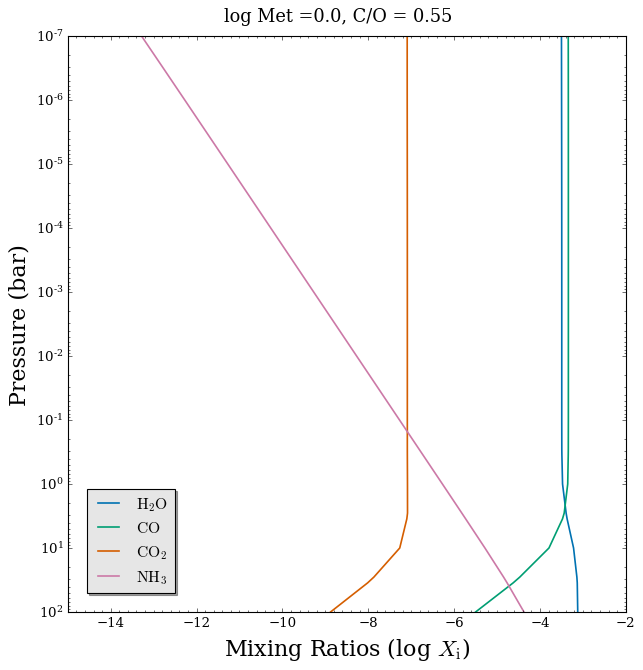

In [9]:
# Define a colour blind friendly colour list
CB_colour_cycle = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']

# Plot mixing ratio profiles
fig_chem = plot_chem(planet, model_full, atmosphere_full, colour_list = CB_colour_cycle,
                     plot_species = ['H2O', 'CO', 'CO2', 'NH3'],   # Just 4 of the 28 included chemical species
                     legend_location = 'lower left')

# Add plot title
fig_chem.suptitle('log Met =' + str(log_Met) + ', C/O = ' + str(C_to_O), fontsize = 16, y = 0.94)

Text(0.5, 0.94, 'log Met =0.0, C/O = 0.55')

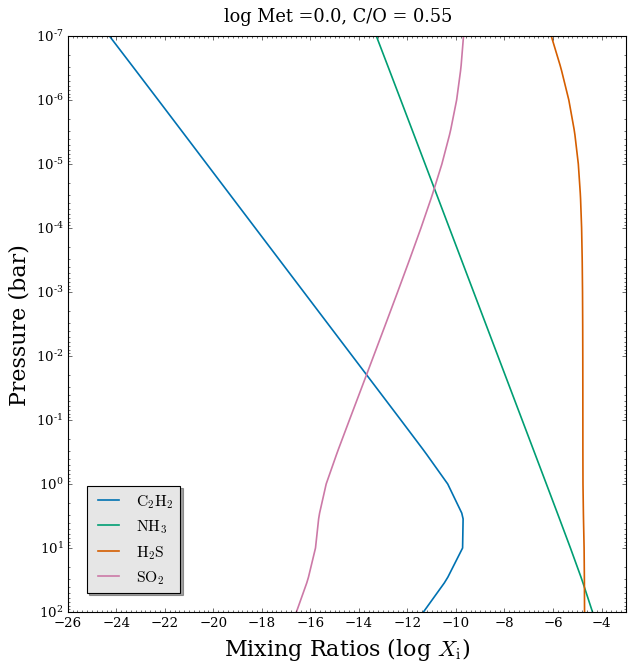

In [10]:
# Plot mixing ratio profiles
fig_chem_2 = plot_chem(planet, model_full, atmosphere_full, colour_list = CB_colour_cycle,
                       plot_species = ['C2H2', 'NH3', 'H2S', 'SO2'],   # Another 4 of the 28 included chemical species
                       legend_location = 'lower left')

# Add plot title
fig_chem_2.suptitle('log Met =' + str(log_Met) + ', C/O = ' + str(C_to_O), fontsize = 16, y = 0.94)

### Load Opacities

In [11]:
from POSEIDON.core import wl_grid_constant_R, read_opacities

#***** Wavelength grid *****#
 
wl_min = 0.5       # Minimum wavelength (um)
wl_max = 5.5       # Maximum wavelength (um)
R = 10000          # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Pre-interpolate the sampled opacities for both models (the subset will be faster!)
opac_subset = read_opacities(model_subset, wl, opacity_treatment, T_fine, log_P_fine)
opac_full = read_opacities(model_full, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CH4 done
CO done
CO2 done
Opacity pre-interpolation complete.
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
N2-H2 done
CO2-CO2 done
CO2-CH4 done
N2-N2 done
N2-H2O done
O2-O2 done
O2-CO2 done
O2-N2 done
C2H2 done
CH4 done
CO done
CO2 done
CaH done
CrH done
FeH done
H2O done
H2S done
HCN done
K done
MgH done
N2 done
NH3 done
NO done
NO2 done
Na done
O2 done
O3 done
OH done
PH3 done
SH done
SO2 done
SiH done
SiO done
TiH done
TiO done
VO done
Opacity pre-interpolation complete.


As you can see, one disadvantage of using the full equilibrium database is that more time and RAM is required to handle all the opacities. If you know *a priori* that a given chemical species is not important (e.g. its absorption features lie outside the wavelength range you are modelling), consider using a subset model excluding the non-important chemical species.

### Compute Transmission Spectrum

Now we can create transmission spectra for both the full equilibrium model and the subset model.

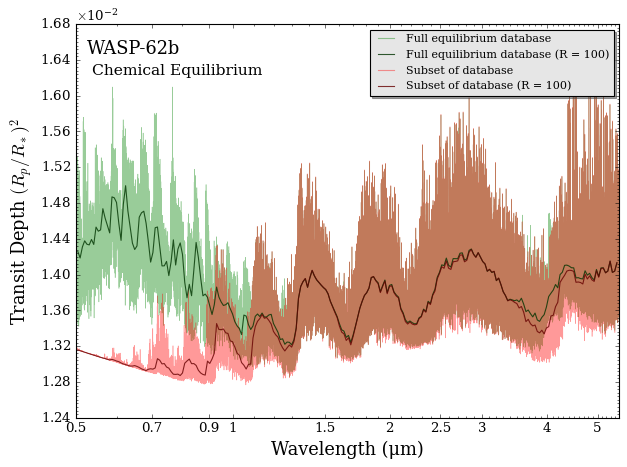

In [ ]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate transmission spectra
spectrum_full = compute_spectrum(planet, star, model_full, atmosphere_full, 
                                 opac_full, wl, spectrum_type = 'transmission')
spectrum_subset = compute_spectrum(planet, star, model_subset, atmosphere_subset, 
                                   opac_subset, wl, spectrum_type = 'transmission')

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = []
spectra = plot_collection(spectrum_full, wl, collection = spectra)
spectra = plot_collection(spectrum_subset, wl, collection = spectra)

# Produce figure and save to file
fig = plot_spectra(spectra, planet, R_to_bin = 100, 
                   y_min = 1.24e-2, y_max = 1.68e-2,
                   spectra_labels = ['Full equilibrium database', 'Subset of database'],
                   plt_label = 'Chemical Equilibrium')

We see that the subset model produces a very similar transmission spectrum from 1.4-3.5 μm (where $\rm{H}_2 \rm{O}$ dominates the opacity), but deviates around 4 μm and at visible wavelengths. Can you guess which chemical species should be added to the subset model to make the two models closely agree? Try adding them!

Let's see how the runtime of the two models compare:

In [13]:
print("Time to compute a spectrum for the full equilibrium database:")
%timeit compute_spectrum(planet, star, model_full, atmosphere_full, opac_full, wl, spectrum_type = 'transmission')

Time to compute a spectrum for the full equilibrium database:
309 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print("Time to compute a spectrum for subset of equilibrium database")
%timeit compute_spectrum(planet, star, model_subset, atmosphere_subset, opac_subset, wl, spectrum_type = 'transmission')

Time to compute a spectrum for subset of equilibrium database
129 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we see the subset model is over 2x faster than the full chemical equilibrium database. You can always use the full database for peace of mind, but it can be informative to use a subset of chemical species to get a feel for how removing certain chemical species impacts the resulting spectrum. 